In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd

from colors import Colors

%matplotlib inline

In [2]:
connection = sq.connect("./measurements.db")
connection.row_factory = sq.Row

65.71297118574685


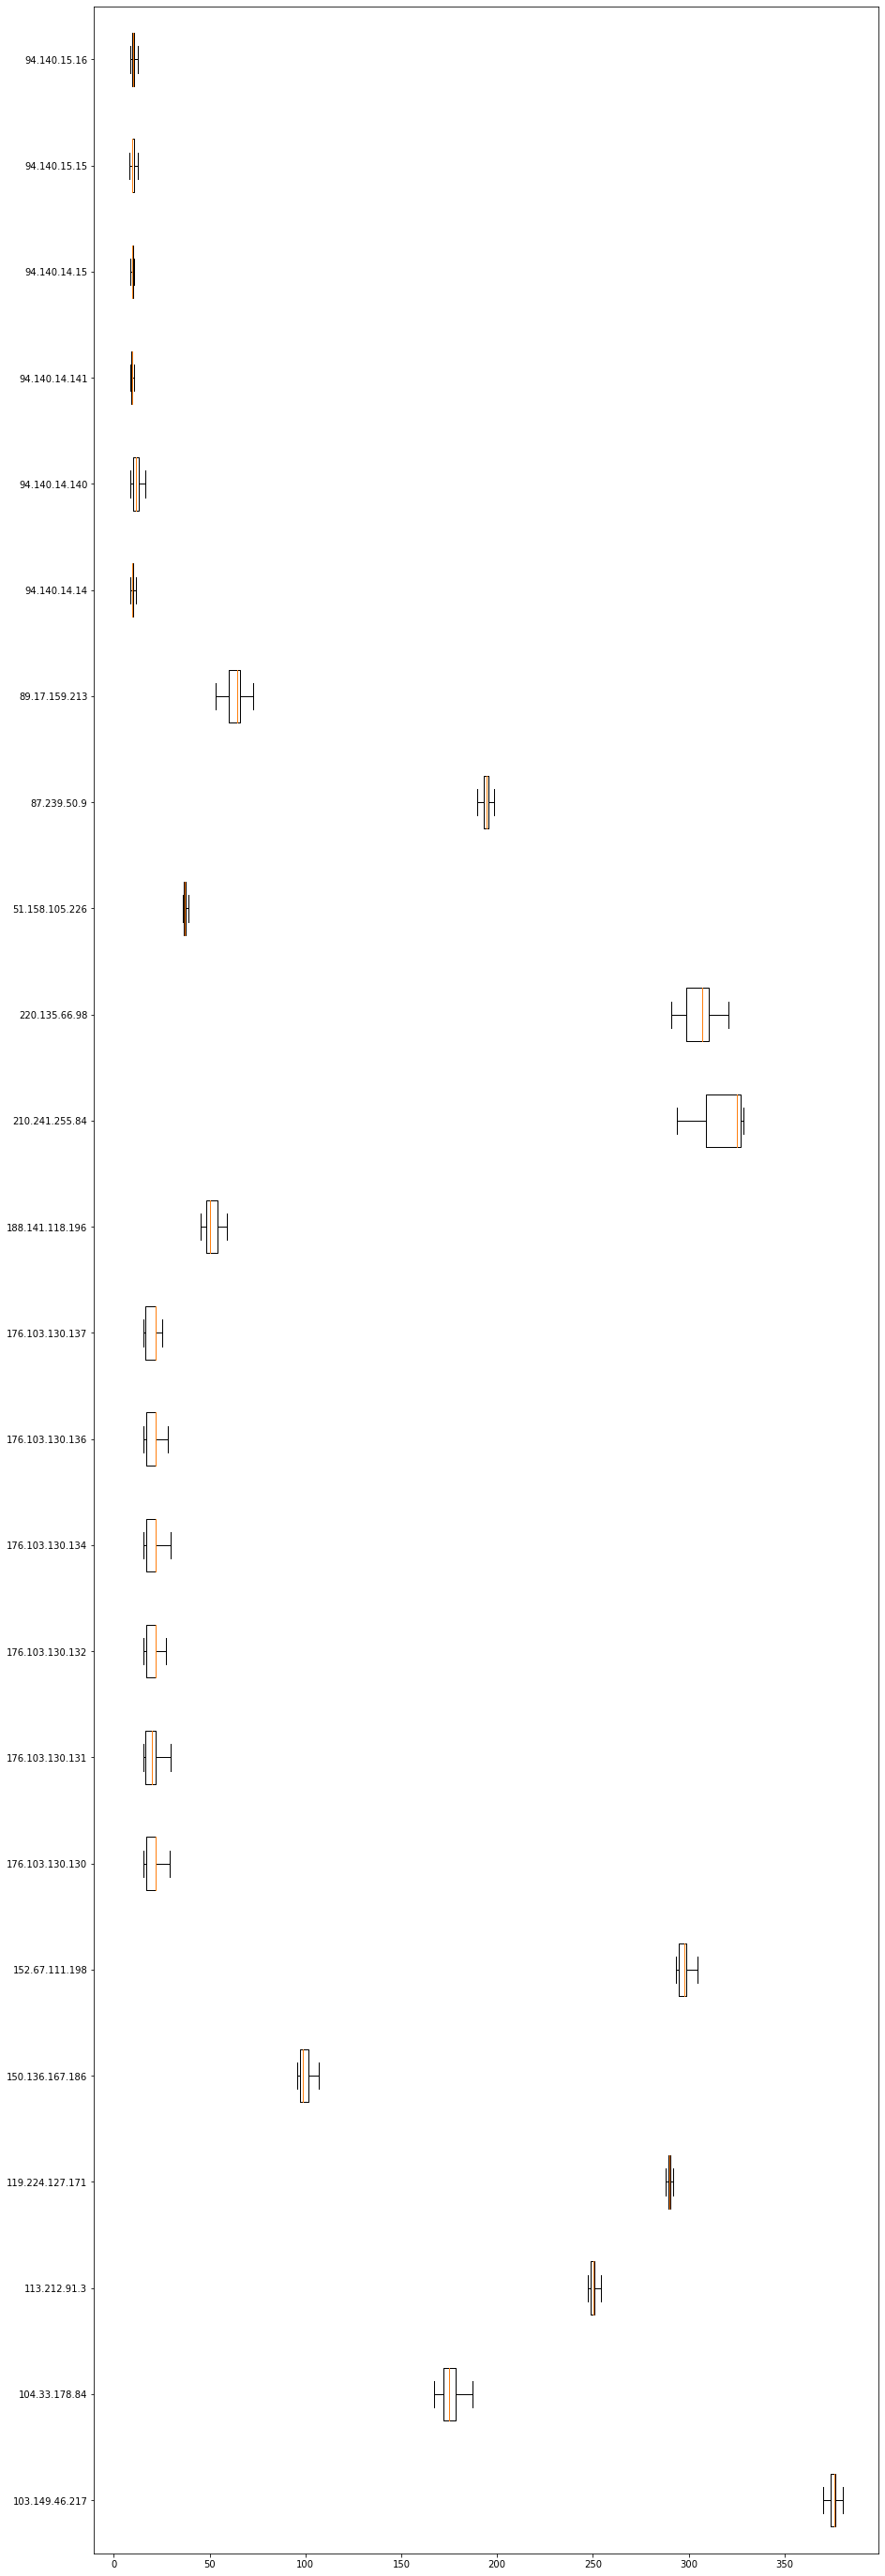

In [31]:
def getTraceroutesForProtocolPairwise(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT dest_ip, rtt from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})) 
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'udp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'quic' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tcp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tls' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'https' AND hop_ip = dest_ip);
    """.format(protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

df = getTraceroutesForProtocolPairwise("quic")
df["rtt"] = df["rtt"].div(1000000)
grouped = df.groupby("dest_ip")
lists = grouped["rtt"].apply(list).reset_index(name = "rtts").head(100)

fig = plt.figure(figsize = (15, 50))
ax = fig.add_subplot(111)
bp = ax.boxplot(lists["rtts"].tolist(), vert = 0, showfliers = False)

ax.set_yticklabels(lists["dest_ip"].tolist())

print(df["rtt"].mean())

plt.show()

In [59]:
def getTraceroutesForProtocolPairwise(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT protocol, dest_ip, rtt from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})) 
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'udp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'quic' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tcp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tls' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'https' AND hop_ip = dest_ip);
    """.format(protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

df_quic = getTraceroutesForProtocolPairwise("quic")
df_tcp = getTraceroutesForProtocolPairwise("tcp")
df_udp = getTraceroutesForProtocolPairwise("udp")
df_tls = getTraceroutesForProtocolPairwise("tls")
df_https = getTraceroutesForProtocolPairwise("https")

In [62]:
merged = pd.concat([df_quic, df_tcp, df_udp, df_tls, df_https])
merged["rtt"] = merged["rtt"].div(1000000)
merged = merged.groupby(["dest_ip", "protocol"]).mean()
pd.set_option('display.max_rows', merged.shape[0]+1)
merged

rtt
dest_ip         protocol            
103.149.46.217  https     374.293348
                quic      374.265560
                tcp       373.053330
                tls       373.990603
                udp       374.717034
104.33.178.84   https     174.745584
                quic      175.500302
                tcp       174.276577
                tls       174.425833
                udp       175.334816
113.212.91.3    https     250.964139
                quic      250.662588
                tcp       250.718788
                tls       250.757339
                udp       250.564582
119.224.127.171 https     289.600553
                quic      289.935640
                tcp       288.911719
                tls       289.476951
                udp       289.170401
150.136.167.186 https      99.653323
                quic       99.793489
                tcp        99.821759
                tls        99.265591
                udp        99.980664
152.67.111.198  https     298.109975
                quic      297.873981
                tcp       298.069799
                tls       298.005174
                udp       298.043746
176.103.130.130 https      21.191070
                quic       19.881844
                tcp        20.851803
                tls        24.158544
                udp        19.843129
176.103.130.131 https      21.820506
                quic       19.835067
                tcp        22.466312
                tls        25.589814
                udp        20.032007
176.103.130.132 https      21.051777
                quic       19.790795
                tcp        21.515343
                tls        21.313735
                udp        20.030689
176.103.130.134 https      21.429637
                quic       20.059013
                tcp        21.377139
                tls        21.412745
                udp        19.726519
176.103.130.136 https      21.755097
                quic       20.098902
                tcp        21.647446
                tls        21.603757
                udp        20.037462
176.103.130.137 https      19.822515
                quic       19.756762
                tcp        19.548618
                tls        19.742281
                udp        19.766047
188.141.118.196 https      49.249367
                quic       65.562856
                tcp        50.194831
                tls        59.755387
                udp        51.797647
210.241.255.84  https     295.610099
                quic      317.027490
                tcp       296.490658
                tls       295.968185
                udp       296.291804
220.135.66.98   https     305.281595
                quic      304.623959
                tcp       304.879895
                tls       304.510050
                udp       303.744491
51.158.105.226  https      38.624805
                quic       37.172775
                tcp        38.571406
                tls        38.683171
                udp        37.183950
87.239.50.9     https     197.575865
                quic      201.462238
                tcp       202.607893
                tls       200.922141
                udp       201.980415
89.17.159.213   https      64.196338
                quic       63.634621
                tcp        62.633459
                tls        63.898840
                udp        63.249812
94.140.14.14    https      11.358137
                quic       10.106235
                tcp        11.201247
                tls        11.145672
                udp         9.941125
94.140.14.140   https      16.106504
                quic       12.267275
                tcp        15.872780
                tls        15.730877
                udp        11.853591
94.140.14.141   https       9.847056
                quic       14.114658
                tcp         9.697277
                tls         9.863763
                udp        15.065094
94.140.14.15    https      10.317437
                quic       10.082867


,dest_ip,rtt
0,103.149.46.217,3.747170e+08
1,104.33.178.84,1.753348e+08
2,113.212.91.3,2.505646e+08
3,119.224.127.171,2.891704e+08
4,150.136.167.186,9.998066e+07
5,152.67.111.198,2.980437e+08
6,176.103.130.130,1.984313e+07
7,176.103.130.131,2.003201e+07
8,176.103.130.132,2.003069e+07
9,176.103.130.134,1.972652e+07
